# Exploratory Analysis of IMDB Movie Reviews

This notebook presents an exploratory data analysis of user reviews collected from IMDB for a selected group of films.   The analysis includes data inspection, statistical summaries, and visual exploration of key variables such as review ratings, review helpfulness, and textual content.  
The goal is to gain a deeper understanding of the structure, distribution, and quality of the review data, in preparation for further natural language processing or predictive modeling tasks.

## Setup: Installing and Importing Required Libraries

In [21]:
import subprocess
import sys

# List of required packages
required_packages = [
    "imdbpy",      
    "pandas",
    "tqdm",
    "numpy",
    "matplotlib",
    "seaborn"
]

def install_package(package):
    """Installs a package using pip if it's not already installed."""
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install missing packages
for package in required_packages:
    install_package(package)


Installing imdbpy...
Defaulting to user installation because normal site-packages is not writeable
pandas is already installed.
tqdm is already installed.
numpy is already installed.
matplotlib is already installed.
seaborn is already installed.


In [22]:
# Import core libraries
import os                   # For file and path operations
import pickle               # For saving/loading serialized data
from collections import Counter  # For frequency counting
from itertools import combinations  # For generating genre pairs

# Import data analysis and visualization libraries
import pandas as pd         # For data manipulation and analysis
import numpy as np          # For numerical operations
import matplotlib.pyplot as plt  # For plotting

# IMDb API (for external data retrieval, if used later)
from imdb import IMDb  # type: ignore

## IMDb Data Download

This cell ensures that the required IMDb datasets (`title.basics.tsv.gz` and `title.ratings.tsv.gz`) are available locally in the `Dataset` folder.  
If the files are not found, they are automatically downloaded from the official IMDb dataset repository.  
The downloaded files contain metadata on movies (e.g., titles, genres, release years) and user ratings, which are essential for the subsequent analysis.

In [23]:
# Define folder and file paths
dataset_folder = "../Dataset"
movieInfo_path = os.path.join(dataset_folder, "title.basics.tsv.gz")
ratings_path = os.path.join(dataset_folder, "title.ratings.tsv.gz")

# Ensure the dataset folder exists
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)
    print(f"Folder '{dataset_folder}' created.")

# IMDb dataset URLs
basics_url = "https://datasets.imdbws.com/title.basics.tsv.gz"
ratings_url = "https://datasets.imdbws.com/title.ratings.tsv.gz"

# Function to download a file if it does not exist
def download_if_needed(file_path, url):
    if not os.path.exists(file_path):
        print(f"{file_path} not found. Downloading from {url}...")
        df = pd.read_csv(url, sep="\t", compression="gzip", low_memory=False)
        df.to_csv(file_path, sep="\t", compression="gzip", index=False)
        print(f"{file_path} downloaded and saved in '{dataset_folder}'.")
    else:
        print(f"{file_path} already exists in '{dataset_folder}'. Skipping download.")

# Download datasets if not already present
download_if_needed(movieInfo_path, basics_url)
download_if_needed(ratings_path, ratings_url)

../Dataset/title.basics.tsv.gz already exists in '../Dataset'. Skipping download.
../Dataset/title.ratings.tsv.gz already exists in '../Dataset'. Skipping download.


## Preprocessing and Merging IMDb Movie Data

This cell performs preprocessing on the IMDb metadata and ratings files to construct a clean and structured dataset of movies.  
It includes the following steps:

- Filtering the metadata to retain only entries classified as "movie"
- Merging metadata (`title.basics`) with user ratings (`title.ratings`) on the unique movie identifier (`tconst`)
- Handling missing values by setting absent ratings and vote counts to `None`
- Selecting relevant columns (e.g., title, year, duration, genres, rating, number of votes) and renaming them for clarity
- Removing entries with missing ratings or genres to ensure data quality

The resulting dataset is saved as a `.csv` file and will be used for further analysis of movie characteristics and popularity.

In [24]:
# Define folder and file paths
dataset_folder = "../Dataset"
title_basics_path = os.path.join(dataset_folder, "title.basics.tsv.gz")
ratings_path = os.path.join(dataset_folder, "title.ratings.tsv.gz")

# Load the datasets
print("Loading datasets...")
title_basics = pd.read_csv(title_basics_path, sep="\t", compression="gzip", low_memory=False)
title_ratings = pd.read_csv(ratings_path, sep="\t", compression="gzip", low_memory=False)

# Filter for movies
print("Filtering for movies...")
movies_only = title_basics[title_basics["titleType"].isin({"movie"})]

# Merge basics and ratings datasets
print("Merging datasets...")
merged_movies = pd.merge(movies_only, title_ratings, on="tconst", how="left")

# Handle missing ratings by setting them to None
merged_movies["averageRating"] = merged_movies["averageRating"].where(merged_movies["averageRating"].notna(), None)

# If averageRating is None, ensure numVotes is also None
merged_movies.loc[merged_movies["averageRating"].isna(), "numVotes"] = None

# Select required columns and rename them
movies_dataset = merged_movies[["tconst", "primaryTitle", "startYear", "runtimeMinutes", "genres", "averageRating", "numVotes"]].copy()

# Rename columns for clarity
movies_dataset.rename(columns={
    "tconst": "MovieID",
    "primaryTitle": "Title",
    "startYear": "Year",
    "runtimeMinutes": "Duration",
    "genres": "Genres",
    "averageRating": "Rating",
    "numVotes": "NumVotes"
}, inplace=True)

# Filter datasets further
movies_with_ratings = movies_dataset[movies_dataset["Rating"].notna()]
movies_with_genres = movies_dataset[movies_dataset["Genres"] != "\\N"]
final_dataset = movies_with_ratings[movies_with_ratings["Genres"] != "\\N"]
#final_dataset.loc[:, "Reviews"] = None

# Print the total number of titles in the final dataset
print(f"Total number of titles in final dataset: {len(final_dataset)}")

Loading datasets...
Filtering for movies...
Merging datasets...
Total number of titles in final dataset: 322222


### Saving the Final Dataset

This cell serializes the cleaned and filtered movie dataset using the `pickle` module.  
The resulting `final_dataset.pkl` file is saved locally and can be efficiently reloaded in future sessions for analysis or modeling purposes.

In [25]:
# Specify the path where you want to save the file
file_path = "../Dataset/final_dataset.pkl"

# Save the dataset
with open(file_path, 'wb') as file:
    pickle.dump(final_dataset, file)

print(f"final_dataset has been saved to {file_path}.")

final_dataset has been saved to ../Dataset/final_dataset.pkl.


### Loading the Final Dataset from Pickle

This test cell checks whether the serialized movie dataset (`final_dataset.pkl`) exists in the specified directory.  
If the file is found, it is loaded using the `pickle` module and stored as a DataFrame for further analysis.  
The first few rows of the dataset are displayed to confirm successful loading and verify the data structure.


In [26]:
# Load the dataset from the pickle file
file_path = "../Dataset/final_dataset.pkl"

# Check if the file exists before loading
if not os.path.exists(file_path):
    print(f"File {file_path} does not exist. Please check the path.")
else:
    with open(file_path, 'rb') as file:
        final_dataset = pickle.load(file)
        
# Display the first few rows of the dataset
final_dataset.head()

,MovieID,Title,Year,Duration,Genres,Rating,NumVotes
0,tt0000009,Miss Jerry,1894,45,Romance,5.3,226.0
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,100,"Documentary,News,Sport",5.2,562.0
3,tt0000574,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",6.0,1003.0
4,tt0000591,The Prodigal Son,1907,90,Drama,5.2,33.0
5,tt0000615,Robbery Under Arms,1907,\N,Drama,3.9,29.0


## Exploratory Data Analysis of the IMDb Movie Dataset

This cell provides a quantitative overview of the IMDb metadata and ratings, offering insight into the size and composition of the available data.  
It reports the total number of titles in the full IMDb database, the subset corresponding to movies, and the availability of ratings and genre information.  
The analysis concludes by summarizing how many titles are retained in the final cleaned dataset, which includes only movies with both rating and genre information—ensuring data completeness for further analysis.


In [27]:
# DATABASE ANALYSIS
print("\nDATABASE ANALYSIS")

# Total titles in the IMDb database (from title.basics)
total_titles_imdb = len(title_basics)
print("\n=== IMDb Database (title.basics) ===")
print(f"Total number of titles in the IMDb database: {total_titles_imdb}")

# Titles that are NOT movies
non_movies_imdb = len(title_basics[~title_basics["titleType"].isin({"movie"})])
print(f"   - Number of titles that are NOT movies: {non_movies_imdb}")

# Movies in the IMDb database
movies_imdb = len(movies_only)
print(f"   - Number of movies in the IMDb database: {movies_imdb}")

# Titles with ratings (from title.ratings)
print("\n=== IMDb Ratings Data (title.ratings) ===")
total_titles_with_ratings = len(title_ratings)
print(f"Total number of titles with ratings available: {total_titles_with_ratings}")

# Movies without ratings
movies_without_ratings_count = len(movies_dataset[movies_dataset["Rating"].isna()])

# Movies with ratings
movies_with_ratings_count = len(movies_with_ratings)

# Movies without genres
movies_without_genres_count = len(movies_dataset[movies_dataset["Genres"] == "\\N"])

# Movies with both ratings and genres (final dataset)
final_movies_count = len(final_dataset)

# Total number of elements included in the final dataset
total_elements_merged_dataset = len(merged_movies)
print("\n=== Final Dataset ===")
print(f"Total number of movies included in the merged dataset: {total_elements_merged_dataset}")
print(f"   - Movies without ratings: {movies_without_ratings_count}")
print(f"   - Movies with ratings: {movies_with_ratings_count}")
print(f"   - Movies without genres: {movies_without_genres_count}")
print(f"   - Movies with ratings and genres (final dataset): {final_movies_count}")

print(f"\nSo, the final dataset contains {final_movies_count} movies")


DATABASE ANALYSIS

=== IMDb Database (title.basics) ===
Total number of titles in the IMDb database: 11733193
   - Number of titles that are NOT movies: 11014907
   - Number of movies in the IMDb database: 718286

=== IMDb Ratings Data (title.ratings) ===
Total number of titles with ratings available: 1600477

=== Final Dataset ===
Total number of movies included in the merged dataset: 718286
   - Movies without ratings: 384823
   - Movies with ratings: 333463
   - Movies without genres: 77122
   - Movies with ratings and genres (final dataset): 322222

So, the final dataset contains 322222 movies


### Genre Frequency Analysis

This cell analyzes the distribution of movie genres within the final dataset.  
By iterating through the `Genres` column, it counts how many times each individual genre appears across all movies.  
The result is a frequency distribution that highlights the most and least common genres represented in the dataset, providing insight into its thematic composition.


In [28]:
# Initialize a counter to track genre frequencies
genre_counts = Counter()

# Iterate through the 'Genres' column and count occurrences of each genre
for genres in final_dataset['Genres'].dropna():
    for genre in genres.split(','):
        genre_counts[genre.strip()] += 1

# Display the result
print(genre_counts)


Counter({'Drama': 150165, 'Comedy': 80077, 'Documentary': 53492, 'Romance': 36291, 'Action': 33919, 'Crime': 28842, 'Thriller': 27936, 'Horror': 26059, 'Adventure': 20047, 'Mystery': 13179, 'Family': 12647, 'Biography': 10388, 'Fantasy': 10057, 'History': 9316, 'Music': 8347, 'Sci-Fi': 7860, 'Musical': 6973, 'War': 6646, 'Animation': 5898, 'Western': 5396, 'Adult': 4541, 'Sport': 4171, 'Film-Noir': 887, 'News': 682, 'Reality-TV': 92, 'Talk-Show': 28, 'Game-Show': 6})


### Counting Single-Genre Movies

This cell identifies and counts movies in the dataset that are associated with only **one genre** (i.e., no genre combinations).  
It iterates through the `Genres` column, filters out entries with multiple genres (identified by commas), and computes the frequency distribution of single-genre movies.  
This analysis helps highlight which genres are most commonly used alone rather than in combination with others.

In [29]:
# Initialize a counter for single-genre movies
genre_counts_new = Counter()

# Check if the 'Genres' column exists in the dataset
if 'Genres' in final_dataset.columns:
    # Count occurrences only for single-genre entries (no commas)
    for genres in final_dataset['Genres'].dropna():
        if ',' not in genres:  # Ensure the genre is not a combination
            genre_counts_new[genres.strip()] += 1

    # Display the result
    print(genre_counts_new)
else:
    print("The 'Genres' column does not exist in the dataset.")

Counter({'Drama': 56597, 'Documentary': 36376, 'Comedy': 26664, 'Horror': 8531, 'Thriller': 5180, 'Action': 4782, 'Romance': 3185, 'Adult': 2722, 'Crime': 1801, 'Adventure': 1799, 'Family': 1705, 'Animation': 1054, 'Western': 1033, 'Sci-Fi': 1023, 'Musical': 937, 'Mystery': 766, 'Music': 728, 'Fantasy': 700, 'War': 542, 'Biography': 505, 'History': 393, 'Sport': 253, 'Reality-TV': 34, 'Talk-Show': 12, 'News': 8, 'Game-Show': 2})


### Visualizing Genre Distribution

This cell creates a histogram to visualize the frequency distribution of movie genres in the final dataset.  
It uses the data previously collected with the `Counter` to display the number of occurrences for each genre.  
The plot provides an intuitive overview of which genres are most and least represented, supporting a better understanding of the dataset's thematic balance.

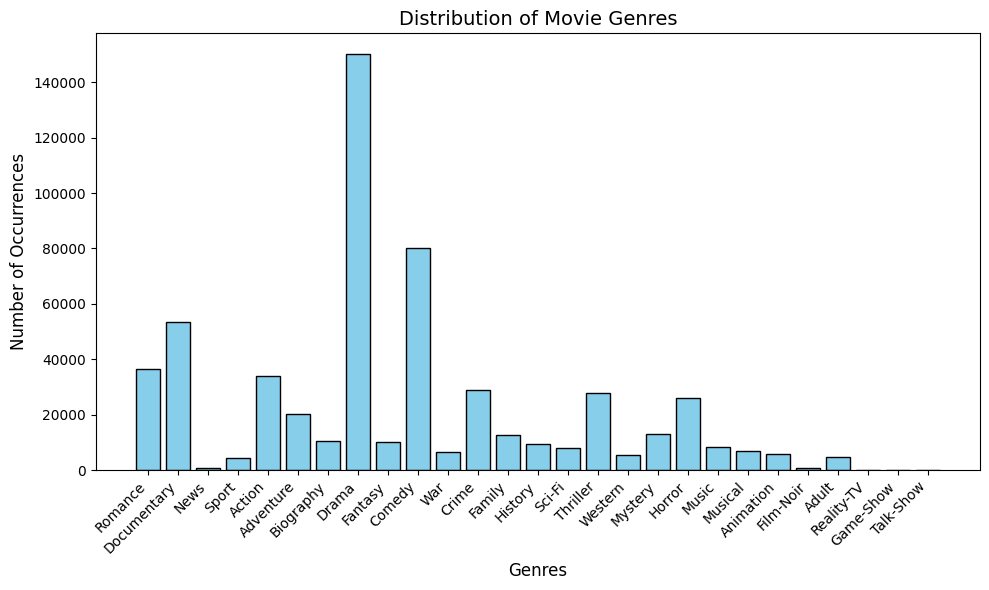

In [30]:
# Convert the Counter into two lists: genres and counts
genres = list(genre_counts.keys())
counts = list(genre_counts.values())

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(genres, counts, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.title('Distribution of Movie Genres', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels for better readability

# Display the histogram
plt.tight_layout()
plt.show()


### Visualizing Most Frequent Single-Genre Movies

This cell generates a histogram showing only the genres that appear more than 500 times among movies with a **single genre**.  
By focusing on the most common single-genre entries, the visualization highlights dominant genres in cases where no genre combinations are present.  
Bar labels are included to make the exact counts easily interpretable.

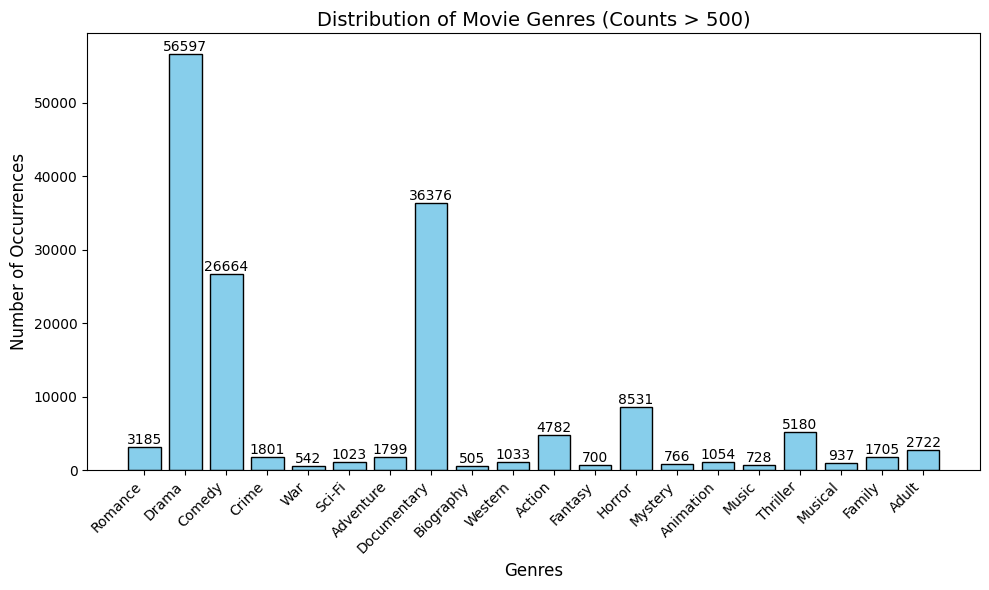

In [31]:
# Filter genres and counts for values greater than 500
filtered_genres = [genre for genre, count in genre_counts_new.items() if count > 500]
filtered_counts = [count for count in genre_counts_new.values() if count > 500]

# Create the histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(filtered_genres, filtered_counts, color='skyblue', edgecolor='black')

# Add numbers above each bar
for bar in bars:
    height = bar.get_height()  # Get the height of each bar
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5,  # Position the text
             str(int(height)), ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.title('Distribution of Movie Genres (Counts > 500)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels for better readability

# Display the histogram
plt.tight_layout()
plt.show()



### Displaying Western Movies with Sufficient Votes

This cell filters and displays all movies in the dataset that belong exclusively to the **Western** genre and have received at least **200 user votes**.  
This allows for identifying Western films that have garnered a minimum level of audience engagement, making them more relevant for reliable analysis or recommendation purposes.

In [32]:
# Display movies with the genre 'Western' and at least 200 votes
display(final_dataset[(final_dataset['Genres'] == 'Western') & (final_dataset['NumVotes'] >= 200)])

,MovieID,Title,Year,Duration,Genres,Rating,NumVotes
12303,tt0019976,Hell's Heroes,1929,68,Western,7.2,1109.0
12728,tt0020502,Tide of Empire,1929,73,Western,6.1,274.0
14695,tt0023121,Law and Order,1932,72,Western,6.8,365.0
15053,tt0023604,Tombstone Canyon,1932,62,Western,5.4,218.0
17116,tt0026273,The Desert Trail,1935,54,Western,5.2,1092.0
...,...,...,...,...,...,...,...
221654,tt0903131,All Hat,2007,89,Western,5.1,600.0
244466,tt1078917,The Only Good Indian,2009,114,Western,6.6,382.0
356310,tt1623660,Redemption: For Robbing the Dead,2011,105,Western,5.7,237.0
646329,tt6361832,Winnetou - Das Geheimnis vom Silbersee,2016,94,Western,5.3,563.0


### Genre Co-occurrence Analysis and Visualization

This section analyzes how often different movie genres co-occur within the same film and visualizes these relationships using a heatmap.  
The process includes the following steps:

1. Counting how many times each pair of genres appears together across all movies.
2. Filtering to include only genres that appear in at least 499 movies to focus on dominant categories.
3. Constructing a symmetric co-occurrence matrix for valid genres, where each cell contains the number of times two genres co-occur.
4. Masking the upper triangular part of the matrix to avoid redundancy.
5. Removing weak associations (co-occurrences fewer than 10) by setting them to zero.
6. Applying a logarithmic transformation to smooth out high-frequency values and highlight subtle patterns.
7. Displaying the lower triangular part of the log-scaled matrix as a heatmap.

This visualization reveals genre pairings that frequently occur in multi-genre films, offering insights into common thematic combinations in cinema.

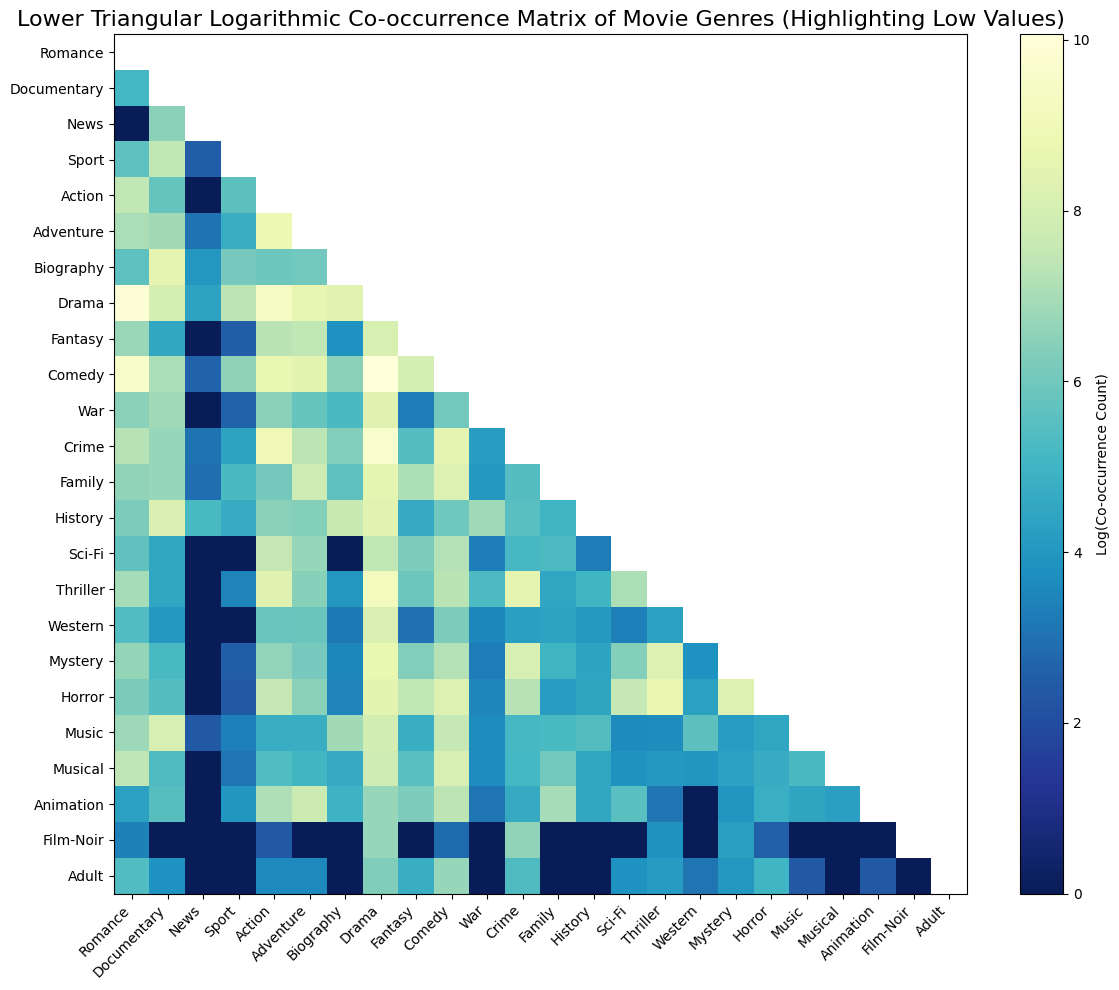

In [33]:
# Step 1: Extract genres and count their co-occurrences
co_occurrence_counts = Counter()
genre_counts = Counter()

for genres in final_dataset['Genres'].dropna():
    genre_list = [g.strip() for g in genres.split(',')]
    for genre in genre_list:
        genre_counts[genre] += 1  # Count occurrences of each genre
    for pair in combinations(genre_list, 2):
        co_occurrence_counts[tuple(sorted(pair))] += 1  # Count co-occurrences

# Step 2: Keep only genres with at least 499 occurrences
valid_genres = [genre for genre, count in genre_counts.items() if count >= 499]

# Step 3: Build symmetric co-occurrence matrix
co_occurrence_matrix = pd.DataFrame(0, index=valid_genres, columns=valid_genres)

for (g1, g2), count in co_occurrence_counts.items():
    if g1 in valid_genres and g2 in valid_genres:
        co_occurrence_matrix.loc[g1, g2] = count
        co_occurrence_matrix.loc[g2, g1] = count

# Step 4: Mask upper triangle
mask = np.triu(np.ones_like(co_occurrence_matrix, dtype=bool))
co_occurrence_matrix_masked = co_occurrence_matrix.where(~mask)

# Step 5: Set low values (<10) to 0
co_occurrence_matrix_masked[co_occurrence_matrix_masked < 10] = 0

# Step 6: Apply logarithmic scale
log_co_occurrence_matrix_masked = np.log1p(co_occurrence_matrix_masked)

# Step 7: Create heatmap
plt.figure(figsize=(12, 10))
plt.imshow(log_co_occurrence_matrix_masked, cmap='YlGnBu_r', aspect='auto')

plt.xticks(np.arange(len(valid_genres)), valid_genres, rotation=45, ha='right')
plt.yticks(np.arange(len(valid_genres)), valid_genres)
plt.colorbar(label='Log(Co-occurrence Count)')
plt.title('Lower Triangular Logarithmic Co-occurrence Matrix of Movie Genres (Highlighting Low Values)', fontsize=16)
plt.tight_layout()
plt.show()


### Displaying the Genre Co-occurrence Matrix

This cell displays the full symmetric co-occurrence matrix of movie genres before masking or transformation.  
Each cell represents the number of times two genres appear together in the same movie, offering a quantitative view of genre pairings across the dataset.

In [34]:
display(co_occurrence_matrix)

,Romance,Documentary,News,Sport,Action,Adventure,Biography,Drama,Fantasy,Comedy,...,Sci-Fi,Thriller,Western,Mystery,Horror,Music,Musical,Animation,Film-Noir,Adult
Romance,0,164,3,283,1710,1141,283,21651,842,13683,...,290,1059,212,775,480,910,1651,74,29,210
Documentary,164,0,666,1688,325,999,5265,2990,92,1178,...,93,88,55,181,233,3253,205,236,0,45
News,3,666,0,11,2,20,54,79,0,13,...,0,3,0,2,1,10,0,4,0,0
Sport,283,1688,11,0,275,120,457,1592,11,694,...,9,32,3,11,10,28,21,50,8,9
Action,1710,325,2,275,0,6908,377,12793,1506,6034,...,1754,4317,341,743,1770,119,216,1235,10,36
Adventure,1141,999,20,120,6908,0,412,5896,1747,4769,...,829,622,355,446,633,118,156,2249,6,35
Biography,283,5265,54,457,377,412,0,4479,46,633,...,9,53,24,34,31,1003,106,138,2,8
Drama,21651,2990,79,1592,12793,5896,4479,0,3345,23498,...,1702,10147,3424,6027,4822,2922,2385,815,805,554
Fantasy,842,92,0,11,1506,1747,46,3345,0,2941,...,500,366,19,575,1688,120,245,520,1,116
Comedy,13683,1178,13,694,6034,4769,633,23498,2941,0,...,1379,1510,501,1335,3744,1825,3242,1600,16,809
